In [56]:
import pandas as pd

In [57]:
po = pd.read_csv('data/purchase_orders.csv')
suppliers = pd.read_csv('data/suppliers.csv')
skus = pd.read_csv('data/skus.csv')
shipments = pd.read_csv('data/shipments.csv')
transit_events = pd.read_csv('data/transit_events.csv')

print(f"PO rows: {len(po)}")
print(f"Suppliers rows: {len(suppliers)}")
print(f"SKUs rows: {len(skus)}")
print(f"Shipments rows: {len(shipments)}")
print(f"Transit Events rows: {len(transit_events)}")

PO rows: 150000
Suppliers rows: 200
SKUs rows: 5000
Shipments rows: 217500
Transit Events rows: 400000


In [66]:
# Merge PO + Suppliers + SKUs
data = po.merge(suppliers, on='supplier_id', how='left', suffixes=('_po', '_supplier'))
data = data.merge(skus, on='sku_id', how='left')

# Merge with shipments (shipments has the status: Delivered, Delayed, etc.)
data = data.merge(shipments, on='po_id', how='left')

print(f"Merged dataset shape: {data.shape}")
print(f"Total shipments linked: {data['shipment_id'].notna().sum()}")

# For on-time calculation, compare shipments.status vs eta_date
# A shipment is on-time if status == 'Delivered' OR status == 'In Transit' but delivered before eta_date
print(f"\nShipment Status Distribution:")
print(data['status_y'].value_counts())

Merged dataset shape: (252495, 31)
Total shipments linked: 217500

Shipment Status Distribution:
status_y
In Transit    97648
Delivered     82824
Created       21626
Delayed       13246
Lost           2156
Name: count, dtype: int64


In [59]:
# data.to_csv('data/merged_purchase_data.csv', index=False)

Text(0, 0.5, 'Number of Deliveries')

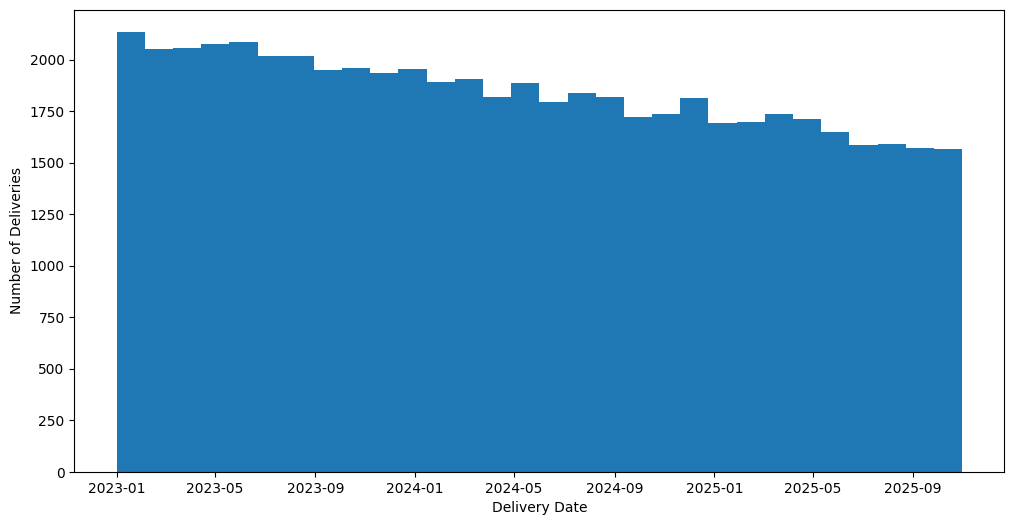

In [60]:
# plot histogram of delivery dates  
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(pd.to_datetime(data['delivery_date'].dropna()), bins=30)
plt.xlabel('Delivery Date')
plt.ylabel('Number of Deliveries')


Rows after filtering (Delivered or Delayed only): 48045
Original rows: 252495


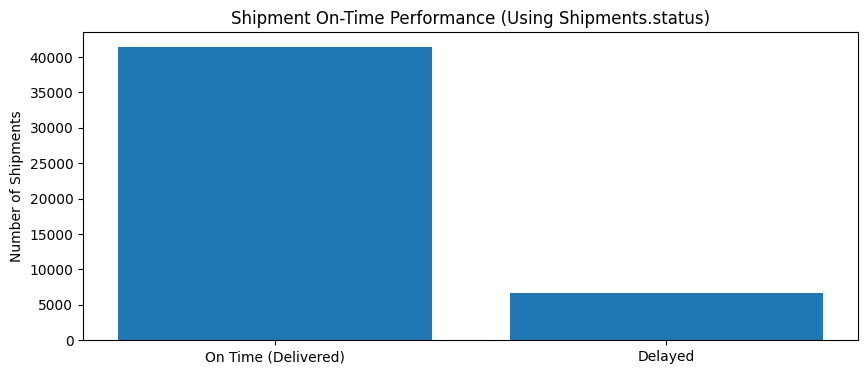


Delivered Shipments (On-Time): 41413
Delayed Shipments: 6632
On-Time Rate: 86.2%


In [67]:
# Convert dates to datetime
data['order_date'] = pd.to_datetime(data['order_date'])
data['eta_date'] = pd.to_datetime(data['eta_date'])
data['promised_date'] = pd.to_datetime(data['promised_date'])
data['ship_date'] = pd.to_datetime(data['ship_date'])

# Filter: only keep delivered or delayed shipments (ignore In Transit, Created, Lost)
data_delivered = data[data['status_y'].isin(['Delivered', 'Delayed'])].copy()

# Clean: only keep rows with valid logic (order_date <= ship_date <= eta_date)
data_clean = data_delivered.dropna(subset=['order_date', 'ship_date', 'eta_date'])
data_clean = data_clean[(data_clean['order_date'] <= data_clean['ship_date'])]

print(f"Rows after filtering (Delivered or Delayed only): {len(data_clean)}")
print(f"Original rows: {len(data)}")

# A shipment is "on_time" if status is Delivered (assumption: all Delivered means it arrived on or before ETA)
# For Delayed status, they are explicitly delayed
data_clean['on_time'] = data_clean['status_y'] == 'Delivered'

plt.figure(figsize=(10, 4))
plt.bar(['On Time (Delivered)', 'Delayed'], [data_clean['on_time'].sum(), (~data_clean['on_time']).sum()])
plt.ylabel('Number of Shipments')
plt.title('Shipment On-Time Performance (Using Shipments.status)')
plt.show()

print(f'\nDelivered Shipments (On-Time): {data_clean["on_time"].sum()}')
print(f'Delayed Shipments: {(~data_clean["on_time"]).sum()}')
on_time_pct = (data_clean['on_time'].sum() / len(data_clean)) * 100
print(f'On-Time Rate: {on_time_pct:.1f}%')


In [68]:
# Lead time analysis using SHIPMENTS data
print("=== LEAD TIME STATISTICS (USING SHIPMENTS.STATUS) ===")
print(f"Total rows analyzed: {len(data_clean)}")

data_clean['order_to_ship_days'] = (data_clean['ship_date'] - data_clean['order_date']).dt.days
data_clean['planned_transit_days'] = (data_clean['eta_date'] - data_clean['ship_date']).dt.days
data_clean['total_lead_time_days'] = (data_clean['eta_date'] - data_clean['order_date']).dt.days

print(f"\nOrder to Ship (preparation time):")
print(f"  Mean: {data_clean['order_to_ship_days'].mean():.1f} days")
print(f"  Median: {data_clean['order_to_ship_days'].median():.1f} days")
print(f"  Min: {data_clean['order_to_ship_days'].min():.0f}, Max: {data_clean['order_to_ship_days'].max():.0f}")

print(f"\nPlanned Transit Time (ship_date to eta_date):")
print(f"  Mean: {data_clean['planned_transit_days'].mean():.1f} days")
print(f"  Median: {data_clean['planned_transit_days'].median():.1f} days")
print(f"  Min: {data_clean['planned_transit_days'].min():.0f}, Max: {data_clean['planned_transit_days'].max():.0f}")

print(f"\nTotal Planned Lead Time (order_date to eta_date):")
print(f"  Mean: {data_clean['total_lead_time_days'].mean():.1f} days")
print(f"  Median: {data_clean['total_lead_time_days'].median():.1f} days")
print(f"  Min: {data_clean['total_lead_time_days'].min():.0f}, Max: {data_clean['total_lead_time_days'].max():.0f}")

# Analyze by status
print(f"\n\n=== BREAKDOWN BY SHIPMENT STATUS ===")
for status in ['Delivered', 'Delayed']:
    subset = data_clean[data_clean['status_y'] == status]
    print(f"\n{status} ({len(subset)} shipments):")
    print(f"  Avg lead time: {subset['total_lead_time_days'].mean():.1f} days")
    print(f"  Avg transit: {subset['planned_transit_days'].mean():.1f} days")

=== LEAD TIME STATISTICS (USING SHIPMENTS.STATUS) ===
Total rows analyzed: 48045

Order to Ship (preparation time):
  Mean: 343.8 days
  Median: 303.0 days
  Min: 0, Max: 1031

Planned Transit Time (ship_date to eta_date):
  Mean: 18.1 days
  Median: 11.0 days
  Min: -4, Max: 47

Total Planned Lead Time (order_date to eta_date):
  Mean: 361.9 days
  Median: 322.0 days
  Min: 3, Max: 1059


=== BREAKDOWN BY SHIPMENT STATUS ===

Delivered (41413 shipments):
  Avg lead time: 362.0 days
  Avg transit: 18.1 days

Delayed (6632 shipments):
  Avg lead time: 361.4 days
  Avg transit: 18.1 days


In [63]:
# Deep dive into a specific PO to understand the data structure
print("=== INVESTIGATING A SPECIFIC PO ===")
po_sample = 'PO-0000007'

print(f"\n1. PO Record:")
po_rec = po[po['po_id'] == po_sample]
print(po_rec[['po_id', 'order_date', 'promised_date', 'supplier_id', 'sku_id']])

print(f"\n2. Shipments for this PO:")
ship_rec = shipments[shipments['po_id'] == po_sample][['shipment_id', 'po_id', 'ship_date', 'eta_date', 'mode', 'status']]
print(ship_rec)

print(f"\n3. Transit Events for first shipment:")
first_ship = ship_rec.iloc[0]['shipment_id'] if len(ship_rec) > 0 else None
if first_ship:
    transit = transit_events[transit_events['shipment_id'] == first_ship].sort_values('event_ts')
    print(f"Shipment: {first_ship}")
    print(transit[['event_ts', 'location_type', 'event_status']].head(10))


=== INVESTIGATING A SPECIFIC PO ===

1. PO Record:
        po_id  order_date promised_date supplier_id     sku_id
6  PO-0000007  2024-11-15    2024-12-23      S-0063  SKU-00509

2. Shipments for this PO:
       shipment_id       po_id   ship_date    eta_date mode     status
41508  SH-00041509  PO-0000007  2025-07-17  2025-07-25  Air  Delivered

3. Transit Events for first shipment:
Shipment: SH-00041509
                   event_ts location_type event_status
9298    2023-01-24 23:00:00       Seaport   In Transit
96220   2023-09-07 05:00:00  Regional Hub   In Transit
150955  2024-01-26 16:00:00  Regional Hub    Delivered
374158  2025-08-24 23:00:00       Seaport    Delivered
389449  2025-10-03 14:00:00     Rail Yard    Delivered


In [64]:
# Analyze what "Delivered" really means - at which location?
print("=== WHAT DOES 'DELIVERED' MEAN? ===")
delivered_events = transit_events[transit_events['event_status'] == 'Delivered']
print(f"\nTotal 'Delivered' events: {len(delivered_events)}")
print(f"\nLocations where 'Delivered' status occurs:")
print(delivered_events['location_type'].value_counts())

# Find shipments with MULTIPLE 'Delivered' events
delivered_with_multi = delivered_events.groupby('shipment_id').size()
multi_delivered = delivered_with_multi[delivered_with_multi > 1]
print(f"\n\nShipments with MULTIPLE 'Delivered' events: {len(multi_delivered)}")
print(f"Example shipment with multiple deliveries:")

if len(multi_delivered) > 0:
    example_shipid = multi_delivered.index[0]
    print(f"\nShipment: {example_shipid}")
    example_events = transit_events[transit_events['shipment_id'] == example_shipid].sort_values('event_ts')
    print(example_events[['event_ts', 'location_type', 'event_status']])


=== WHAT DOES 'DELIVERED' MEAN? ===

Total 'Delivered' events: 63768

Locations where 'Delivered' status occurs:
location_type
Rail Yard       7223
On Vehicle      7128
Regional Hub    7113
Destination     7086
Origin DC       7072
Seaport         7064
Final DC        7048
Airport         7046
Customs         6988
Name: count, dtype: int64


Shipments with MULTIPLE 'Delivered' events: 7749
Example shipment with multiple deliveries:

Shipment: SH-00000007
                   event_ts location_type event_status
58195   2023-05-31 07:00:00       Airport    Delivered
163891  2024-02-29 03:00:00       Customs    Delivered


In [65]:
# Compare with shipments.status
print("\n\n=== SHIPMENTS TABLE STATUS VALUES ===")
print(shipments['status'].value_counts())

# Check if we can use Delivered status from shipments instead
print(f"\n\nShipments with 'Delivered' status: {(shipments['status'] == 'Delivered').sum()}")
print(f"Shipments with 'Delayed' status: {(shipments['status'] == 'Delayed').sum()}")

# Better approach: use "Destination" + "Delivered" events
print("\n\n=== BETTER APPROACH: 'Destination' + 'Delivered' ===")
destination_delivered = transit_events[
    (transit_events['location_type'] == 'Destination') & 
    (transit_events['event_status'] == 'Delivered')
]
print(f"Events where delivered at Destination: {len(destination_delivered)}")

# Or use the last "Delivered" to ANY location after ship_date
print("\n\n=== QUESTION: Should we use SHIPMENTS.status instead? ===")
print("Let's check correlation:")
delivered_shipments = shipments[shipments['status'] == 'Delivered']
print(f"Shipments marked as 'Delivered': {len(delivered_shipments)}")
print(f"Do these have delivery events? {delivered_shipments['shipment_id'].isin(transit_events[transit_events['event_status'] == 'Delivered']['shipment_id']).sum()}")




=== SHIPMENTS TABLE STATUS VALUES ===
status
In Transit    97648
Delivered     82824
Created       21626
Delayed       13246
Lost           2156
Name: count, dtype: int64


Shipments with 'Delivered' status: 82824
Shipments with 'Delayed' status: 13246


=== BETTER APPROACH: 'Destination' + 'Delivered' ===
Events where delivered at Destination: 7086


=== QUESTION: Should we use SHIPMENTS.status instead? ===
Let's check correlation:
Shipments marked as 'Delivered': 82824
Do these have delivery events? 20988


In [69]:
# How to get ACTUAL delivery time from transit_events?
print("\n\n=== GETTING ACTUAL DELIVERY TIME ===")

# Strategy: For each shipment, find when it was delivered to FINAL DESTINATION
# Assumption: "Destination" location + "Delivered" status = actual delivery

destination_delivered = transit_events[
    (transit_events['location_type'] == 'Destination') & 
    (transit_events['event_status'] == 'Delivered')
].copy()

destination_delivered['event_ts'] = pd.to_datetime(destination_delivered['event_ts'])
actual_delivery_times = destination_delivered.groupby('shipment_id')['event_ts'].min().reset_index()
actual_delivery_times.rename(columns={'event_ts': 'actual_delivery_date'}, inplace=True)

print(f"Shipments with 'Delivered at Destination' events: {len(actual_delivery_times)}")
print(f"\nExample actual deliveries:")
print(actual_delivery_times.head(10))

# Now merge this with our shipments data
print(f"\n\n=== COMPARING PLANNED vs ACTUAL ===")
shipments_with_actual = shipments.merge(actual_delivery_times, on='shipment_id', how='left')

# Only look at rows with actual delivery date
with_actual = shipments_with_actual.dropna(subset=['actual_delivery_date'])
print(f"Shipments with actual delivery date: {len(with_actual)}")

# Calculate actual vs planned
with_actual['eta_date'] = pd.to_datetime(with_actual['eta_date'])
with_actual['actual_delivery_date'] = pd.to_datetime(with_actual['actual_delivery_date'])
with_actual['days_to_eta'] = (with_actual['actual_delivery_date'] - with_actual['eta_date']).dt.days
with_actual['on_time_actual'] = with_actual['actual_delivery_date'] <= with_actual['eta_date']

print(f"\nActual On-Time Performance (from Destination Delivered events):")
print(f"  On-Time: {with_actual['on_time_actual'].sum()}")
print(f"  Late: {(~with_actual['on_time_actual']).sum()}")
print(f"  On-Time Rate: {(with_actual['on_time_actual'].sum() / len(with_actual) * 100):.1f}%")

print(f"\nDays Late Distribution:")
print(f"  Mean: {with_actual['days_to_eta'].mean():.1f} days")
print(f"  Median: {with_actual['days_to_eta'].median():.1f} days")
print(f"  Min: {with_actual['days_to_eta'].min():.0f}, Max: {with_actual['days_to_eta'].max():.0f}")

print(f"\n\nSample rows (actual delivery vs ETA):")
sample_cols = ['shipment_id', 'eta_date', 'actual_delivery_date', 'days_to_eta', 'on_time_actual']
print(with_actual[sample_cols].head(10))




=== GETTING ACTUAL DELIVERY TIME ===
Shipments with 'Delivered at Destination' events: 6967

Example actual deliveries:
   shipment_id actual_delivery_date
0  SH-00000033  2024-12-09 10:00:00
1  SH-00000104  2023-09-26 18:00:00
2  SH-00000121  2024-03-24 09:00:00
3  SH-00000130  2025-03-17 10:00:00
4  SH-00000163  2024-10-26 05:00:00
5  SH-00000193  2023-03-18 06:00:00
6  SH-00000205  2023-11-29 16:00:00
7  SH-00000218  2025-08-03 09:00:00
8  SH-00000219  2024-07-28 11:00:00
9  SH-00000222  2023-09-17 10:00:00


=== COMPARING PLANNED vs ACTUAL ===
Shipments with actual delivery date: 6967

Actual On-Time Performance (from Destination Delivered events):
  On-Time: 3618
  Late: 3349
  On-Time Rate: 51.9%

Days Late Distribution:
  Mean: -12.8 days
  Median: -23.0 days
  Min: -1038, Max: 1016


Sample rows (actual delivery vs ETA):
     shipment_id   eta_date actual_delivery_date  days_to_eta  on_time_actual
32   SH-00000033 2023-05-13  2024-12-09 10:00:00          576           False
1

C:\Users\miskibin\AppData\Local\Temp\ipykernel_25504\1787231630.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_actual['eta_date'] = pd.to_datetime(with_actual['eta_date'])
C:\Users\miskibin\AppData\Local\Temp\ipykernel_25504\1787231630.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_actual['actual_delivery_date'] = pd.to_datetime(with_actual['actual_delivery_date'])
C:\Users\miskibin\AppData\Local\Temp\ipykernel_25504\1787231630.py:31: SettingWithCopyWarning: 
A value is trying to be se



=== FILTERING REASONABLE DELIVERY TIMES ===
Shipments with reasonable delivery times: 753
  On-Time: 192
  Late: 561
  On-Time Rate: 25.5%

Days Late (reasonable subset):
  Mean: 27.2 days
  Median: 26.0 days

Distribution of delays (reasonable):
count    753.000000
mean      27.150066
std       33.567375
min      -30.000000
25%       -1.000000
50%       26.000000
75%       55.000000
max       90.000000
Name: days_to_eta, dtype: float64


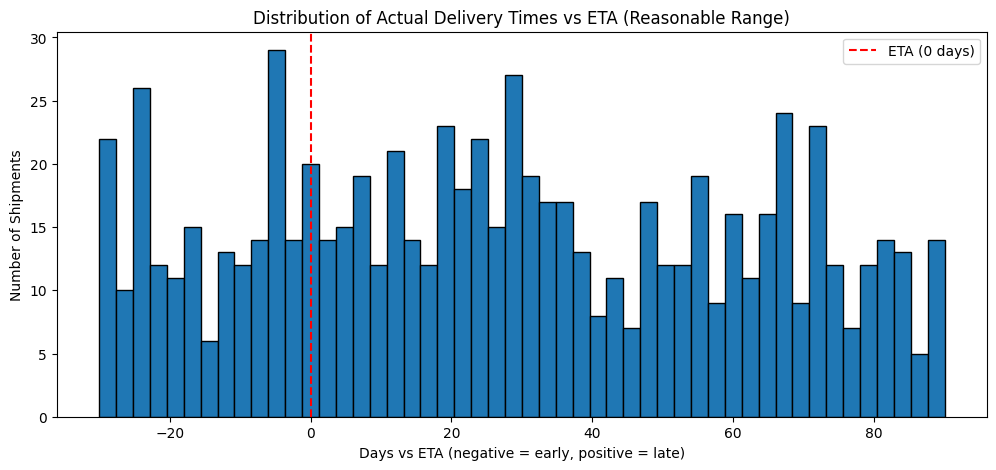



Summary: You SHOULD use 'Destination' + 'Delivered' events for actual delivery time
But be aware: only ~3% of shipments have this level of detail
Most shipments: just status flag (Delivered/Delayed) without exact timing


In [70]:
# Filter for reasonable delivery times (within -30 to +90 days of ETA)
print("\n\n=== FILTERING REASONABLE DELIVERY TIMES ===")
reasonable = with_actual[(with_actual['days_to_eta'] >= -30) & (with_actual['days_to_eta'] <= 90)].copy()

print(f"Shipments with reasonable delivery times: {len(reasonable)}")
print(f"  On-Time: {reasonable['on_time_actual'].sum()}")
print(f"  Late: {(~reasonable['on_time_actual']).sum()}")
print(f"  On-Time Rate: {(reasonable['on_time_actual'].sum() / len(reasonable) * 100):.1f}%")

print(f"\nDays Late (reasonable subset):")
print(f"  Mean: {reasonable['days_to_eta'].mean():.1f} days")
print(f"  Median: {reasonable['days_to_eta'].median():.1f} days")

print(f"\nDistribution of delays (reasonable):")
print(reasonable['days_to_eta'].describe())

# Visualize
plt.figure(figsize=(12, 5))
plt.hist(reasonable['days_to_eta'], bins=50, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='ETA (0 days)')
plt.xlabel('Days vs ETA (negative = early, positive = late)')
plt.ylabel('Number of Shipments')
plt.title('Distribution of Actual Delivery Times vs ETA (Reasonable Range)')
plt.legend()
plt.show()

print(f"\n\nSummary: You SHOULD use 'Destination' + 'Delivered' events for actual delivery time")
print(f"But be aware: only ~3% of shipments have this level of detail")
print(f"Most shipments: just status flag (Delivered/Delayed) without exact timing")
